### Concat all HIBP and Analyze

In [1]:
import glob
import os
import re
import logging
import pandas as pd
import numpy as np
from tqdm import tqdm
from multiprocessing import Pool

In [2]:
# Directory path containing JSON files
directory = 'pwned/'

logging.basicConfig(filename='error_log_read_json.log', level=logging.ERROR,
                    format='%(asctime)s - %(levelname)s - %(message)s')

# Get list of JSON file paths in the directory
json_files = glob.glob(directory + '/*.json')

# Define a function for processing a JSON file
def process_json_file(file):
    try:
        df = pd.read_json(file)
        file_name = os.path.basename(file).rstrip('.json')
        df['email'] = file_name
        return df
    except ValueError as e:
        logging.error(f"Error reading file: {file}. Error message: {e}")
        return None

# Create a pool of worker processes
pool = Pool()

# Create a progress bar with tqdm
progress_bar = tqdm(total=len(json_files), desc="Processing JSON files", unit="file")

# Process JSON files in parallel
results = []
for df in pool.imap_unordered(process_json_file, json_files):
    results.append(df)
    progress_bar.update(1)

# Close the pool of worker processes
pool.close()
pool.join()

# Close the progress bar
progress_bar.close()

Processing JSON files: 100%|█████████████████████████████████████████████████████████████████████████████████████| 562693/562693 [07:52<00:00, 1191.99file/s]


In [3]:
# Concatenate the list of DataFrames into a single DataFrame
combined_df = pd.concat(results, ignore_index=True)

In [4]:
breaches = pd.read_json('breaches.json')

In [5]:
breached_email_df = pd.merge(combined_df, breaches, on='Name')
breached_email_df.shape

(4248329, 17)

### Let's create an email level dataset for which we have breaches

#### Non-fab
https://haveibeenpwned.com/FAQs#FabricatedBreach

In [6]:
breached_email_df['non_fab'] = ~breached_email_df['IsFabricated'].fillna(1)

#### Serious Dataclasses Breached 
Either data that will help you hack your other accounts, e.g., Mother's Maiden Name, or sensitive personal information

In [7]:
serious_dataclasses = ["Audio recordings",
"Auth tokens",
"Bank account numbers",
"Biometric data",
"Browsing histories",
"Chat logs",
"Credit card CVV",
"Credit cards",
"Credit status information",
"Drinking habits",
"Driver's licenses",
"Drug habits",
"Email messages",
"Encrypted keys",
"Government issued IDs",
"Health insurance information",
"Historical passwords", #account cracking
"HIV statuses",
#"Mothers maiden names", #account cracking
"Partial credit card data",
"Passport numbers",
"Password hints",
"Passwords",
"Personal health data",
"Photos",
"PINs",
"Places of birth", #account cracking
"Private messages",
"Security questions and answers",
"Sexual fetishes",
"Sexual orientations",
"SMS messages",
"Social security numbers",
"Taxation records"]

In [8]:
breached_email_df['serious'] = breached_email_df['DataClasses'].apply(lambda x: any(string in x for string in serious_dataclasses))

In [9]:
br_email_df = breached_email_df.assign(count=1).\
    groupby('email').\
    agg(total_breaches = ('count', 'sum'),
    serious_breaches   = ('serious', 'sum'),
    non_fab_breaches   = ('non_fab', 'sum'),
    non_null_uniques   = ('Name', 'nunique')
).reset_index()
br_email_df

,email,total_breaches,serious_breaches,non_fab_breaches,non_null_uniques
0,0005255SM@GMAIL.COM,10,8,10,10
1,000JOSEPHARCE000@GMAIL.COM,7,5,7,7
2,000JWA@GMAIL.COM,2,1,2,2
3,000WENDYCHONG000@GMAIL.COM,1,1,1,1
4,000uly@gmail.com,9,7,9,9
...,...,...,...,...,...
562685,zzotter@hotmail.com,26,18,26,26
562686,zzouiten@hotmail.com,10,7,10,10
562687,zzz1girl@gmail.com,11,6,11,11
562688,zzzack53@gmail.com,3,0,3,3


### Join to Currently Processed Valid Email List

In [10]:
# Get list of currently processed emails from the logs

def extract_email(log_message):
    if "INFO - Saved" in log_message:
        start_index = log_message.find("Saved") + 6  # Length of "Saved" + space
        end_index = log_message.find("\n")
    elif "Error processing" in log_message and ": 404" in log_message:
        start_index = log_message.find("Error processing") + 18  # Length of "Error processing" + space
        end_index = log_message.find(": 404") # Length of ": 404" + space
    else:
        return None

    email = log_message[start_index:end_index].strip()
    return email

# Read the log file into a list of lines
with open('pwned.log', 'r') as file:
    log_lines = file.readlines()

# Extract emails from log messages and create a list of email addresses
emails = [extract_email(log_line) for log_line in log_lines if "Saved" in log_line or ("Error processing" in log_line and ": 404" in log_line)]

In [11]:
# Subset to non empty uniques
print(len(emails))
print(len(emails[emails == '']))

unique_not_empty_emails = [e for e in set(emails) if e.strip()]
parsed_emails = pd.DataFrame({"email": unique_not_empty_emails})
parsed_emails.shape

706754
23


(678288, 1)

In [12]:
# Merge parsed to valid emails (assuming our population is valid emails)
voter_df = pd.read_csv("pwned_scripts/fl_emails_valid_or_not.csv")

parsed_voter = parsed_emails.merge(voter_df, how = 'left')
parsed_valid = parsed_voter[parsed_voter['is_valid_email'] == True]
parsed_valid.shape

(571072, 8)

In [13]:
# Merge breaches to parsed
fin_df = pd.merge(parsed_valid, br_email_df, how = 'left', on = 'email')

In [14]:
fin_df.fillna(0).describe()

,race,total_breaches,serious_breaches,non_fab_breaches,non_null_uniques
count,571072.000000,571072.000000,571072.000000,571072.000000,571072.000000
mean,4.416925,7.548869,4.569522,7.548852,7.548869
std,1.052067,5.819876,4.070190,5.819684,5.819876
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,3.000000,2.000000,3.000000,3.000000
50%,4.000000,6.000000,4.000000,6.000000,6.000000
75%,5.000000,11.000000,7.000000,11.000000,11.000000
max,9.000000,344.000000,298.000000,344.000000,344.000000


In [15]:
# Focus on DNS validated emails
parsed_valid = parsed_voter[parsed_voter['is_valid_email_dns'] == True]
parsed_valid.shape

(569750, 8)

In [16]:
fin_df = pd.merge(parsed_valid, br_email_df, how = 'left', on = 'email')

In [17]:
fin_df.fillna(0).describe()

,race,total_breaches,serious_breaches,non_fab_breaches,non_null_uniques
count,569750.000000,569750.000000,569750.000000,569750.000000,569750.000000
mean,4.416356,7.549946,4.571128,7.549929,7.549946
std,1.052425,5.819490,4.070133,5.819297,5.819490
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,3.000000,2.000000,3.000000,3.000000
50%,4.000000,6.000000,4.000000,6.000000,6.000000
75%,5.000000,11.000000,7.000000,11.000000,11.000000
max,9.000000,344.000000,298.000000,344.000000,344.000000


In [18]:
fin_df.describe().to_markdown()

'|       |         race |   total_breaches |   serious_breaches |   non_fab_breaches |   non_null_uniques |\n|:------|-------------:|-----------------:|-------------------:|-------------------:|-------------------:|\n| count | 569750       |     568493       |       568493       |       568493       |       568493       |\n| mean  |      4.41636 |          7.56664 |            4.58123 |            7.56662 |            7.56664 |\n| std   |      1.05243 |          5.81507 |            4.06894 |            5.81488 |            5.81507 |\n| min   |      1       |          1       |            0       |            1       |            1       |\n| 25%   |      4       |          3       |            2       |            3       |            3       |\n| 50%   |      4       |          6       |            4       |            6       |            6       |\n| 75%   |      5       |         11       |            7       |           11       |           11       |\n| max   |      9       |   

In [19]:
(fin_df.fillna(0)['total_breaches'] > 0).mean()

0.9977937691970162

In [20]:
fin_df.fillna(0, inplace = True)

### Digital Gap: Sociodemographic Predictors of Breaches

In [21]:
def calculate_summary_statistics(data_df, groupby_column, value_column, percentiles=None):
    """
    Calculate summary statistics for a given DataFrame.

    Parameters:
        data_df (DataFrame): The DataFrame containing the data.
        groupby_column (str): The column to group by.
        value_column (str): The column for which to calculate statistics.
        percentiles (list, optional): List of percentiles to calculate. Default is None.

    Returns:
        DataFrame: A DataFrame with the summary statistics.
    """
    if percentiles is None:
        percentiles = [25, 50, 75]

    # Calculate summary statistics
    summary_stats = data_df.groupby(groupby_column)[value_column].agg(['count', 'mean', 'std', 'min', 'max']).round(1)

    # Calculate percentile values
    percentile_values = data_df.groupby(groupby_column)[value_column].apply(lambda x: pd.Series(np.nanpercentile(x, percentiles), index=percentiles)).unstack().round(1)

    # Merge summary statistics and percentile values
    summary_with_percentiles = pd.merge(summary_stats, percentile_values, left_index=True, right_index=True)

    # Reorder columns
    desired_columns = ['count', 'mean', 'std', 'min'] + percentiles + ['max']
    summary_with_percentiles = summary_with_percentiles.reindex(columns=desired_columns).reset_index()

    return summary_with_percentiles

In [22]:
gen_sum = calculate_summary_statistics(fin_df, 
                                   groupby_column='gender', 
                                   value_column='total_breaches',
                                   percentiles = [25, 50, 75])
print(gen_sum)

  gender   count  mean  std  min   25   50    75    max
0      0      14   8.1  5.2  2.0  4.2  7.0  12.2   19.0
1      F  302030   7.7  5.7  0.0  3.0  7.0  11.0  344.0
2      M  258815   7.4  6.0  0.0  3.0  6.0  11.0  344.0
3      U    8891   6.4  5.5  0.0  3.0  5.0   9.0  195.0


In [23]:
gen_sum.to_markdown()

'|    | gender   |   count |   mean |   std |   min |   25 |   50 |   75 |   max |\n|---:|:---------|--------:|-------:|------:|------:|-----:|-----:|-----:|------:|\n|  0 | 0        |      14 |    8.1 |   5.2 |     2 |  4.2 |    7 | 12.2 |    19 |\n|  1 | F        |  302030 |    7.7 |   5.7 |     0 |  3   |    7 | 11   |   344 |\n|  2 | M        |  258815 |    7.4 |   6   |     0 |  3   |    6 | 11   |   344 |\n|  3 | U        |    8891 |    6.4 |   5.5 |     0 |  3   |    5 |  9   |   195 |'

In [24]:
race_sum = calculate_summary_statistics(fin_df, 
                                   groupby_column='race_lit', 
                                   value_column='total_breaches',
                                   percentiles = [25, 50, 75])
print(race_sum)

           race_lit   count  mean  std  min   25   50    75    max
0             Asian   11374   7.4  5.8  0.0  3.0  6.0  10.0  154.0
1          Hispanic  202029   7.3  5.6  0.0  3.0  6.0  10.0  344.0
2      Multi-Racial    4172   7.3  5.5  0.0  3.0  6.0  10.0   53.0
3          NH Black   77031   7.2  5.8  0.0  3.0  6.0  10.0  344.0
4          NH White  250833   7.9  6.0  0.0  3.0  7.0  11.0  344.0
5  Native Americans    1162   7.4  5.6  0.0  3.0  6.0  10.0   42.0
6             Other   12870   7.6  5.7  0.0  3.0  6.0  11.0   55.0
7           Unknown   10279   6.7  5.7  0.0  3.0  5.0   9.0  195.0


In [25]:
race_sum.to_markdown()

'|    | race_lit         |   count |   mean |   std |   min |   25 |   50 |   75 |   max |\n|---:|:-----------------|--------:|-------:|------:|------:|-----:|-----:|-----:|------:|\n|  0 | Asian            |   11374 |    7.4 |   5.8 |     0 |    3 |    6 |   10 |   154 |\n|  1 | Hispanic         |  202029 |    7.3 |   5.6 |     0 |    3 |    6 |   10 |   344 |\n|  2 | Multi-Racial     |    4172 |    7.3 |   5.5 |     0 |    3 |    6 |   10 |    53 |\n|  3 | NH Black         |   77031 |    7.2 |   5.8 |     0 |    3 |    6 |   10 |   344 |\n|  4 | NH White         |  250833 |    7.9 |   6   |     0 |    3 |    7 |   11 |   344 |\n|  5 | Native Americans |    1162 |    7.4 |   5.6 |     0 |    3 |    6 |   10 |    42 |\n|  6 | Other            |   12870 |    7.6 |   5.7 |     0 |    3 |    6 |   11 |    55 |\n|  7 | Unknown          |   10279 |    6.7 |   5.7 |     0 |    3 |    5 |    9 |   195 |'

In [26]:
# Recode Age

fin_df['age'] = 2022 - pd.to_datetime(fin_df['birth_yr'], format='%m/%d/%Y').dt.year
age_buckets = [0, 25, 50, 65, 120]
labels = ['<25', '25--50', '50--65', '65+'] 

fin_df['age_lab'] = pd.cut(fin_df['age'], bins = age_buckets, labels = labels)
fin_df['age_lab'].value_counts()

age_lab
25--50    259257
50--65    144546
65+       100098
<25        65849
Name: count, dtype: int64

In [27]:
print(calculate_summary_statistics(fin_df, 
                                   groupby_column='age_lab', 
                                   value_column='total_breaches',
                                   percentiles = [25, 50, 75]))

  age_lab   count  mean  std  min   25   50    75    max
0     <25   65849   6.1  5.1  0.0  2.0  5.0   9.0  344.0
1  25--50  259257   7.8  5.8  0.0  3.0  7.0  11.0  344.0
2  50--65  144546   7.9  6.0  0.0  3.0  7.0  11.0  210.0
3     65+  100098   7.4  5.9  0.0  3.0  6.0  11.0  344.0


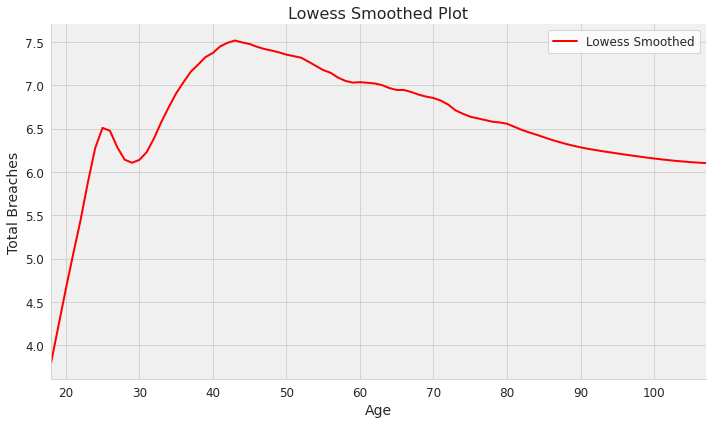

In [28]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from matplotlib.ticker import MultipleLocator

lowess = sm.nonparametric.lowess

lowess_model = lowess(fin_df['total_breaches'], fin_df['age'], frac=0.07)

# Create the plot using seaborn and matplotlib
sns.set_style("whitegrid")  # Set the plot style
plt.figure(figsize=(10, 6))
plt.plot(lowess_model[:, 0], lowess_model[:, 1], color='red', linewidth=2, label='Lowess Smoothed')

plt.xlabel('Age', fontsize=14)
plt.ylabel('Total Breaches', fontsize=14)
plt.title('Lowess Smoothed Plot', fontsize=16)
plt.legend(fontsize=12)

# Adjust tick label sizes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.gca().xaxis.set_major_locator(MultipleLocator(base=10))
plt.xlim(min(fin_df['age']), max(fin_df['age']))

# Add a light gray background to the plot
plt.gca().set_facecolor('#f0f0f0')

# Remove right and top spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)


plt.tight_layout()

plt.savefig('age_breaches.png', dpi=300)
plt.show()

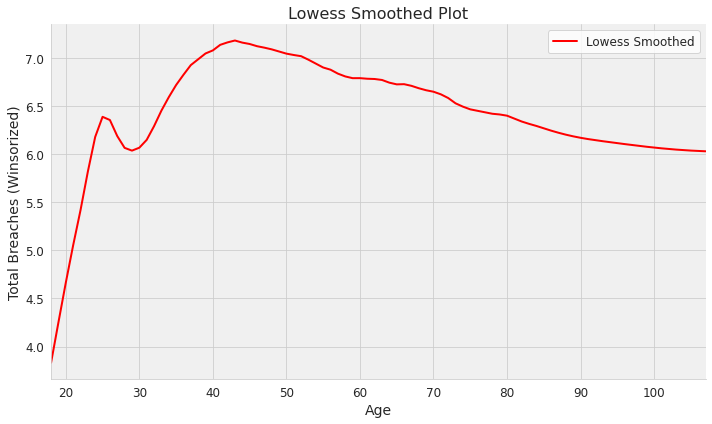

In [29]:
# Let's winsorize or we can lowess over medians
from scipy.stats.mstats import winsorize
winsorized_breaches = winsorize(fin_df['total_breaches'], limits=(0.0, 0.2))

lowess_model = lowess(winsorized_breaches, fin_df['age'], frac=0.07)

# Create the plot using seaborn and matplotlib
sns.set_style("whitegrid")  # Set the plot style
plt.figure(figsize=(10, 6))
plt.plot(lowess_model[:, 0], lowess_model[:, 1], color='red', linewidth=2, label='Lowess Smoothed')

plt.xlabel('Age', fontsize=14)
plt.ylabel('Total Breaches (Winsorized)', fontsize=14)
plt.title('Lowess Smoothed Plot', fontsize=16)
plt.legend(fontsize=12)

# Adjust tick label sizes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.gca().xaxis.set_major_locator(MultipleLocator(base=10))
plt.xlim(min(fin_df['age']), max(fin_df['age']))

# Add a light gray background to the plot
plt.gca().set_facecolor('#f0f0f0')

# Remove right and top spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)


plt.tight_layout()

plt.savefig('age_winsorized_breaches.png', dpi=300)
plt.show()